
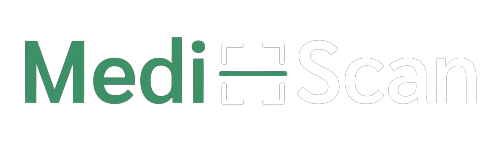

# Mediscan - Skin cancer detection

## Problem Statement
Many if not all diagnoses for critical medical conditions require expensive and specialized tools,
trained personnel to operate the tools, and other medical personalities. Such things can only be
accessed by people in big cities with well equipped hospitals, making many people especially
from rural areas unable to check their symptoms on probable critical medical conditions. Mediscan tries to solve this problem by offering an app that uses image recognition to provide a
cheap and portable screening for many medical conditions. As a research project, our team will
try to create an algorithm that can differentiate several skin conditions including skin cancer. Creating an app that can differentiate the skin conditions.

## Goals


## Workflow



1.   Accuired dataset
2.   EDA
3.   Analize and Explore the data
4.   Create the Model using transfer learning
5.   Make Prediction
7.   Evaluate the model
8.   Transform the model to Tensorflow Lite




### 1. Accuired the dataset

In [12]:
# import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# open the dataset and sanity check.
import os
base_dir = '/content/drive/MyDrive/HAM10000 U-3'
cancer_dir = base_dir + '/CANCER/'
nevi_dir = base_dir + '/NEVI/'
other_disease_dir = base_dir +'/OTHERDISEASE/'

print("total cancer images: ",len(os.listdir(cancer_dir)))  
print("total nevi images: ",len(os.listdir(nevi_dir)))
print("total other disease images: ",len(os.listdir(other_disease_dir)))

#show 10 files from the folder
cancer_files = os.listdir(cancer_dir)
print(cancer_files[:10])

nevi_files = os.listdir(nevi_dir)
print(nevi_files[:10])

other_disease_files = os.listdir(other_disease_dir)
print(other_disease_files[:10])



total cancer images:  1000
total nevi images:  1000
total other disease images:  1000
['ISIC_0024315.jpg', 'ISIC_0024310.jpg', 'ISIC_0024313.jpg', 'ISIC_0024333.jpg', 'ISIC_0024331.jpg', 'ISIC_0024332.jpg', 'ISIC_0024323.jpg', 'ISIC_0024360.jpg', 'ISIC_0024367.jpg', 'ISIC_0024351.jpg']
['ISIC_0024307.jpg', 'ISIC_0024317.jpg', 'ISIC_0024322.jpg', 'ISIC_0024316.jpg', 'ISIC_0024308.jpg', 'ISIC_0024311.jpg', 'ISIC_0024314.jpg', 'ISIC_0024309.jpg', 'ISIC_0024306.jpg', 'ISIC_0024321.jpg']
['ISIC_0024318.jpg', 'ISIC_0024312.jpg', 'ISIC_0024336.jpg', 'ISIC_0024329.jpg', 'ISIC_0024337.jpg', 'ISIC_0024338.jpg', 'ISIC_0024330.jpg', 'ISIC_0024324.jpg', 'ISIC_0024383.jpg', 'ISIC_0024375.jpg']


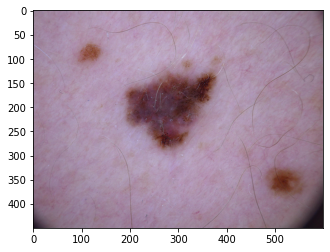

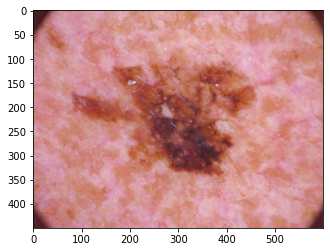

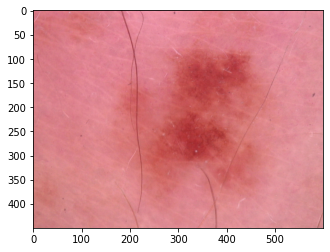

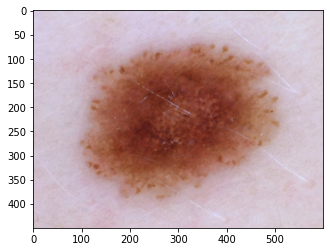

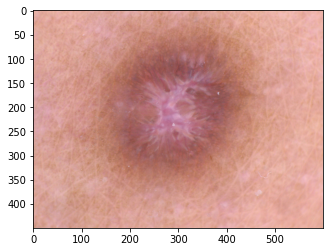

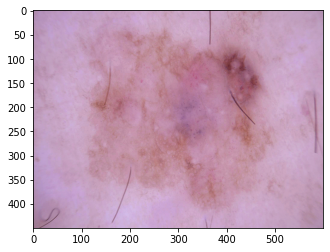

In [14]:
# inspecting the images
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_cancer= [os.path.join(cancer_dir, fname) 
                for fname in cancer_files[pic_index-2:pic_index]]
next_nevi = [os.path.join(nevi_dir, fname) 
                for fname in nevi_files[pic_index-2:pic_index]]
next_other_disease = [os.path.join(other_disease_dir, fname) 
                for fname in other_disease_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_cancer+next_nevi+next_other_disease):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.show()

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import time


In [16]:
# create base model
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=(200,150,3), pooling='max') 
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 200, 150, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [17]:
# custom model
x=base_model.output
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(3, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 200, 150, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [19]:
 train_datagen = ImageDataGenerator(rescale = 1.0/255.,
        validation_split=0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
train_generator = train_datagen.flow_from_directory(base_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(200, 150),
                                                    subset='training')     
validation_generator =  train_datagen.flow_from_directory(base_dir,
                                                         batch_size=16,
                                                         class_mode  = 'categorical',
                                                         subset='validation',
                                                         target_size=(200, 150))

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [20]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (200, 150, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (200, 150,3), (55,65,80)) 
        
    def on_train_batch_begin(self, batch, logs=None):
        msg='{0:83s}{1:4s}of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -5:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-5:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 5: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [21]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [22]:
epochs =100
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =40 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.75 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of the base model
batches=16
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor, dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_generator,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=validation_generator,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /100   16.309   52.750  14.19711  33.333   0.00100  0.00100  accuracy   336.75 

 2 /100   11.802   57.792  11.07579  32.000   0.00100  0.00100  accuracy   58.87  

 3 /100    9.457   59.417   8.82164  34.167   0.00100  0.00100  accuracy   57.38  

 4 /100    7.681   61.208   7.30014  26.667   0.00100  0.00100  accuracy   57.21  

 5 /100    6.249   64.875   6.17509  33.333   0.00100  0.00100  accuracy   58.64  

 6 /100    5.079   66.375   5.13536  33.333   0.00100  0.00100  accuracy   57.35  

 7 /100    4.120   68.875   4.35693  33.167   0.00100  0.00100  accuracy   57.19  

 8 /100    3.325   71.042   4.94911  25.500   0.00100  0.00100  accuracy   58.92  

 9 /100    2.681   73.542   9.17784  34.500   0.00100  0.00100  accuracy   57.46  

10 /100    2.168   75.375  11.94419  31.333   0.00100  0.00100  accuracy   57.54

Text(0.5, 1.0, 'Training and validation loss')

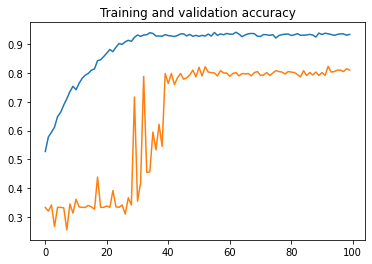

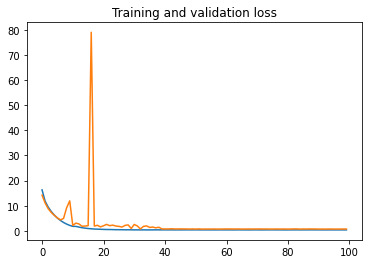

In [23]:
import matplotlib.pyplot as plt

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]   

epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [24]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [25]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
num_of_test_samples = 600
batch_size = 16

Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['CANCER', 'NEVI','OTHERDISEASE']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[59 77 64]
 [61 76 63]
 [66 65 69]]
Classification Report
              precision    recall  f1-score   support

      CANCER       0.32      0.29      0.31       200
        NEVI       0.35      0.38      0.36       200
OTHERDISEASE       0.35      0.34      0.35       200

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.34       600
weighted avg       0.34      0.34      0.34       600



In [27]:
# sove to h5 format
model.save('mediscan_v1.h5')

#Test the Model

In [28]:
new_model = tf.keras.models.load_model('/content/mediscan_v1.h5')

In [29]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 200, 150, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [30]:
image_path = "/content/drive/MyDrive/HAM10000 U-3/OTHERDISEASE/ISIC_0024329.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 150))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)

In [31]:
print(predictions)
idx = np.argmax(predictions)
print(idx)


[[1. 0. 0.]]
0


# Export the model

In [32]:
# mediscan_saved_model3 = "exp_saved_model"

## export the saved model


In [33]:
# tf.saved_model.save(model, mediscan_saved_model3)

In [34]:
# %%bash -s $mediscan_saved_model1
# saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

In [35]:
# loaded = tf.saved_model.load(mediscan_saved_model1)

In [36]:
# print(list(loaded.signatures.keys()))
# infer = loaded.signatures["serving_default"]
# print(infer.structured_input_signature)
# print(infer.structured_outputs)

## Convert Using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [37]:
# converter = tf.lite.TFLiteConverter.from_saved_model(mediscan_saved_model1)

NameError: ignored

### Post-Training Quantization

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
# def representative_data_gen():
#     for input_value, _ in test_batches.take(100):
#         yield [input_value]

In [ ]:
# converter.representative_dataset = representative_data_gen

### convert the model

In [ ]:
# tflite_model = converter.convert()
# tflite_model_file = 'converted_model.tflite'

# with open(tflite_model_file, "wb") as f:
#     f.write(tflite_model)